In [114]:
#list of Import

import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from PIL import Image, ImageFile 
import time
from collections import OrderedDict 
import csv
import pandas as pd
import sys
import itertools
import get_results as results

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.models as models

import time

import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

#pip install torchsummary
from torchsummary import summary

import Helper

# Look at an image

In [115]:
#from PIL import Image
#Image.open(open("data/test/melanoma/ISIC_0012258.jpg", 'rb'))

# Explore data

In [116]:
# load filenames for human and dog images
dataset = np.array(glob("data/*/*/*"))
trainset = np.array(glob("data/train/*/*"))
validset = np.array(glob("data/valid/*/*"))
testset = np.array(glob("data/test/*/*"))
# print number of images in each dataset
print('There are %d total images.' % len(dataset))
print('There are %d total train images.' % len(trainset))
print('There are %d total validation images.' % len(validset))
print('There are %d total test images.' % len(testset))


There are 2750 total images.
There are 2000 total train images.
There are 150 total validation images.
There are 600 total test images.


## Pytorch dataset to be used in Pytorch Dataloader to create batches

In [144]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from utils2 import transform


class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each


## Create Data Lists



In [147]:
def create_data_lists(voc07_path, voc12_path, output_folder):
    """
    Create lists of images, the bounding boxes and labels of the objects in these images, and save these to file.

    :param voc07_path: path to the 'VOC2007' folder
    :param voc12_path: path to the 'VOC2012' folder
    :param output_folder: folder where the JSONs must be saved
    """
    voc07_path = os.path.abspath(voc07_path)
    voc12_path = os.path.abspath(voc12_path)

    train_images = list()
    train_objects = list()
    n_objects = 0

    # Training data
    for path in [voc07_path, voc12_path]:

        # Find IDs of images in training data
        with open(os.path.join(path, 'ImageSets/Main/trainval.txt')) as f:
            ids = f.read().splitlines()

        for id in ids:
            # Parse annotation's XML file
            objects = parse_annotation(os.path.join(path, 'Annotations', id + '.xml'))
            if len(objects) == 0:
                continue
            n_objects += len(objects)
            train_objects.append(objects)
            train_images.append(os.path.join(path, 'JPEGImages', id + '.jpg'))

    assert len(train_objects) == len(train_images)

    # Save to file
    with open(os.path.join(output_folder, 'TRAIN_images.json'), 'w') as j:
        json.dump(train_images, j)
    with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'w') as j:
        json.dump(train_objects, j)
    with open(os.path.join(output_folder, 'label_map.json'), 'w') as j:
        json.dump(label_map, j)  # save label map too

    print('\nThere are %d training images containing a total of %d objects. Files have been saved to %s.' % (
        len(train_images), n_objects, os.path.abspath(output_folder)))

    # Test data
    test_images = list()
    test_objects = list()
    n_objects = 0

    # Find IDs of images in the test data
    with open(os.path.join(voc07_path, 'ImageSets/Main/test.txt')) as f:
        ids = f.read().splitlines()

    for id in ids:
        # Parse annotation's XML file
        objects = parse_annotation(os.path.join(voc07_path, 'Annotations', id + '.xml'))
        if len(objects) == 0:
            continue
        test_objects.append(objects)
        n_objects += len(objects)
        test_images.append(os.path.join(voc07_path, 'JPEGImages', id + '.jpg'))

    assert len(test_objects) == len(test_images)

    # Save to file
    with open(os.path.join(output_folder, 'TEST_images.json'), 'w') as j:
        json.dump(test_images, j)
    with open(os.path.join(output_folder, 'TEST_objects.json'), 'w') as j:
        json.dump(test_objects, j)

    print('\nThere are %d test images containing a total of %d objects. Files have been saved to %s.' % (
        len(test_images), n_objects, os.path.abspath(output_folder)))

In [148]:
if __name__ == '__main__':
    create_data_lists(voc07_path='/media/ssd/ssd data/VOC2007',
                      voc12_path='/media/ssd/ssd data/VOC2012',
                      output_folder='./')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\media\\ssd\\ssd data\\VOC2007\\ImageSets/Main/trainval.txt'



# Data loader

We prepare three types of transform based on the type of data we get. We want the training data to be augmented whereas we don't want for the Valid and Test datatsets

In [117]:
data_dir = 'data/'

train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

image_datasets = {x: datasets.ImageFolder(data_dir + x, transform = train_transforms if x == 'train' else valid_transforms if x == 'valid' else test_transforms) for x in ['train', 'valid', 'test']}

loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}


In [118]:
print(image_datasets['test'])

Dataset ImageFolder
    Number of datapoints: 600
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## Image vizualisation


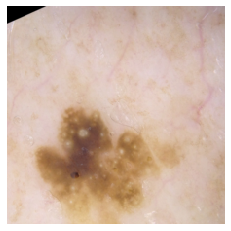

In [120]:
# Visualize different training images

def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
  
  if normalize:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')
  return ax

images, labels = next(iter(loaders_scratch['train']))
imshow(images[7])

## Saving checkpoint element

In [121]:
def save_checkpoint(epoch, model, optimizer, save_path):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer,
             'State_Dict': model.state_dict()
            }
    filename = save_path
    torch.save(state, filename)

# Build model

In [122]:
# Check model for transfer learning

model_transfer = models.vgg16(pretrained=True)

print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 3 type)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 3)

model_transfer.classifier[6] = last_layer

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

4096
1000
3
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

# Train Classifier for VGG16

In [123]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    start = time.time()
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler) 

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime: {:.3f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            time.time() - start
            ))
        start = time.time()
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min and epoch > (n_epochs - 5):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            #torch.save(model.state_dict(), save_path)
            save_checkpoint(epoch, model, optimizer, save_path)
            valid_loss_min = valid_loss
            print('\nCompleted')
            
    # return trained model
    return model

## loss function and optim for VGGG16

In [124]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [125]:
# train the model
n_epochs = 1

loaders_transfer = loaders_scratch

model_transfer =  train(n_epochs, 
                        loaders_transfer, 
                        model_transfer, 
                        optimizer_transfer, 
                        criterion_transfer, 
                        use_cuda, 
                        'model_transfer.pt')

Epoch: 1 	Training Loss: 0.898924 	Validation Loss: 1.097067 	Time: 3666.443
Validation loss decreased (inf --> 1.097067).  Saving model ...

Completed


In [128]:
# load the model that got the best validation accuracy (uncomment the line below)
load = torch.load('model_transfer.pt')
#load['State_Dict']
model_transfer.load_state_dict(load['State_Dict'])


<All keys matched successfully>

In [129]:
summary(model_transfer,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [130]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [131]:
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.881812


Test Accuracy: 65% (393/600)


In [132]:
class_names = [item.replace("_", " ") for item in image_datasets['train'].classes]

def mole_id(img_path):
    # load the image and return the predicted breed
    #image_tensor = image_to_tensor(img_path)
    
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample result
    result = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(result, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

nevus


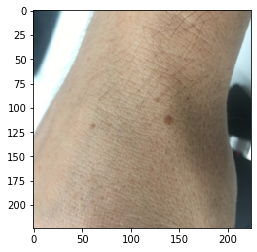

In [133]:
img_path = "test/test.jpg"

print(mole_id(img_path))
#image = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
transformations = transforms.Compose([transforms.Resize(size=224), transforms.CenterCrop((224,224))])
image = transformations(img)
plt.imshow(image)
plt.show()

nevus


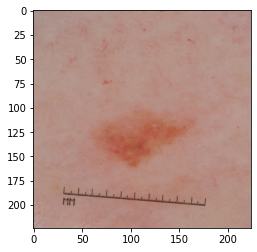

In [134]:
img_path = "data/test/melanoma/ISIC_0013472.jpg"

print(mole_id(img_path))
#image = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
transformations = transforms.Compose([transforms.Resize(size=224), transforms.CenterCrop((224,224))])
image = transformations(img)
plt.imshow(image)
plt.show()

nevus


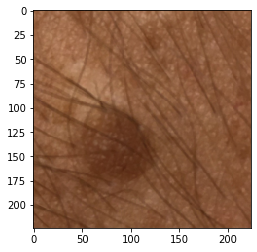

In [135]:
img_path = "test/test2_2.jpg"

print(mole_id(img_path))
#image = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
transformations = transforms.Compose([transforms.Resize(size=224), transforms.CenterCrop((224,224))])
image = transformations(img)
plt.imshow(image)
plt.show()

## Identify on the picture the section that will identified for classification

In [136]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [137]:
model_transfer.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [138]:
model_transfer.parameters()

<generator object Module.parameters at 0x000001F82383A1C8>

In [139]:
optimizer_transfer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [2165254591336,
    2165254591016,
    2165253572712,
    2165253572472,
    2165252961048,
    2165251848056]}]}

In [140]:
criterion_transfer.state_dict()

OrderedDict()

In [142]:
from torchvision import transforms
from utils2 import *
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'model_transfer.pt'
checkpoint = torch.load(checkpoint)


start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])



Loaded checkpoint from epoch 2.



## Test on the whole melanoma test database - no need to run until improved model


In [19]:
res = 0
x = 0
for x in range(len(testset)):
    
    if mole_id(testset[x]) == "Melanoma":
        res += 1
        
print(res)

0


# Evaluate model

The model is ranked according to three separate categories:

- Category 1 (Score 1): ROC AUC for melanoma classification.

    This is the ability to distiguish between malignant melanoma and the benign skin lesions (nevus, seborrheic keratosis) by calculating the area under the receiver operating characteristic curve (ROC AUC)[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html] corresponding to this binary classification task.

- Category 2 (Score 2): ROC AUC for melanocytic classification:

    All of the skin lesions that we will examine are caused by abnormal growth of either melanocytes or keratinocytes, which are two different types of epidermal skin cells. Melanomas and nevi are derived from melanocytes, whereas seborrheic keratoses are derived from keratinocytes. The second caterory tests the ability to distinguish between melanocytic and keratinocytic skin lesions.

- Category 3 (Score 3): Mean ROC AUC:

    This catefory take the average of the ROC AUC values from the first two categories.

# load the model

In [20]:
state_dict = torch.load('model_transfer.pt')
model_transfer.load_state_dict(state_dict)

<All keys matched successfully>

## Get predictions

In [21]:
#img_paths = [line.rstrip('\n') for line in open('paths.txt')] 

#print(len(img_paths))

In [22]:
img_paths = [line.rstrip('\n') for line in testset]

print(len(img_paths))

600


In [23]:
print(img_paths[0])

data/test\melanoma\ISIC_0012258.jpg


In [24]:
print("first five: ", img_paths[:5], "\nMiddle five: ", img_paths[300:305], "\nLast five: ", img_paths[-5:])

first five:  ['data/test\\melanoma\\ISIC_0012258.jpg', 'data/test\\melanoma\\ISIC_0012356.jpg', 'data/test\\melanoma\\ISIC_0012369.jpg', 'data/test\\melanoma\\ISIC_0012395.jpg', 'data/test\\melanoma\\ISIC_0012425.jpg'] 
Middle five:  ['data/test\\nevus\\ISIC_0015217.jpg', 'data/test\\nevus\\ISIC_0015218.jpg', 'data/test\\nevus\\ISIC_0015223.jpg', 'data/test\\nevus\\ISIC_0015224.jpg', 'data/test\\nevus\\ISIC_0015226.jpg'] 
Last five:  ['data/test\\seborrheic_keratosis\\ISIC_0014647.jpg', 'data/test\\seborrheic_keratosis\\ISIC_0014648.jpg', 'data/test\\seborrheic_keratosis\\ISIC_0014649.jpg', 'data/test\\seborrheic_keratosis\\ISIC_0014652.jpg', 'data/test\\seborrheic_keratosis\\ISIC_0014653.jpg']


In [25]:
def load_image(path):
  image = Image.open(path)
  image = test_transforms(image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

def get_predictions(img_paths):
  """ Is melanoma? """
  pred_rank1 = [] # Is melanoma?
  pred_rank2 = [] # Is seborrheic?
  for img_path in img_paths:
    img = load_image(img_path)
    #img.to(device)
    prediction = model_transfer(img)
    #img.to("cpu")
    pred_rank1.append(float(prediction.data[0][0]))
    pred_rank2.append(float(prediction.data[0][2]))
  return pred_rank1, pred_rank2

#model.to("cpu")
#model.eval()
print("")

In [26]:
task1, task2 = get_predictions(img_paths)

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [27]:
print("Task 1 predictions: ", len(task1))
print("first five predictions (Task 1): ", task1[:5])

print("Task 2 predictions: ", len(task2))
print("first five predictions (Task 2): ", task2[:5])

Task 1 predictions:  600
first five predictions (Task 1):  [-0.975540041923523, -0.5728214979171753, -0.4307812452316284, -0.6151629686355591, -0.7784428596496582]
Task 2 predictions:  600
first five predictions (Task 2):  [-0.8443031907081604, -0.3632621765136719, -1.1165472269058228, -0.5413832664489746, -0.767363965511322]


In [28]:
with open('results.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(img_paths)):
    doc.writerow([img_paths[i], task1[i], task2[i]])


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


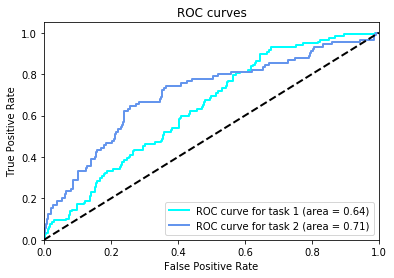

Category 1 Score: 0.639
Category 2 Score: 0.707
Category 3 Score: 0.673


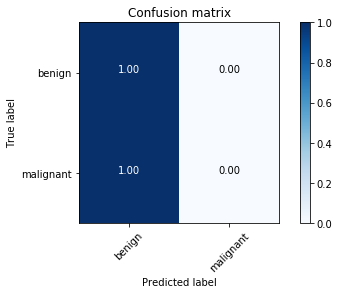

In [29]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
threshold = 0.5 

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv('results.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
results.plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)